In [1]:
import json
import os 
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from rag_fine_tuning import create_vector_store, convert_context_to_langchain_docs
from rag_fine_tuning import query_vector_store, save_llm_answers, fine_tune_rag
from data_utils import convert_json_to_dataframe, create_json_subset, collect_all_results, merge_results
sns.set_style("whitegrid")
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_openai import OpenAIEmbeddings
from dotenv import load_dotenv
load_dotenv()

True

In [2]:
%load_ext autoreload

# Useful material 
# SQuAD Evaluation guidelines: 
# https://worksheets.codalab.org/worksheets/0x8212d84ca41c4150b555a075b19ccc05/
# https://rajpurkar.github.io/SQuAD-explorer/

# Convert json data to pandas dataframe 

In [2]:
convert_json_to_dataframe()

Saving dataframe of shape:  (11873, 14)


In [6]:
df_all_data = pd.read_csv("dataset.csv")
df_all_data.shape

(11873, 14)

In [9]:
df_selected = df_all_data.copy()

In [10]:
# some rough statistics for the context length 
df_selected.loc[:, "context_chars"] = df_selected["context"].apply(lambda x: len(x))
df_selected.loc[:, "context_words"] = df_selected.loc[:, "context"].apply(lambda x: len(x.split(" ")))

In [12]:
df_selected.head(2)

,question,list_idx,paragraph_idx,question_idx,id,is_impossible,answer_0,answer_1,answer_2,answer_3,context,title,answer_4,answer_5,context_chars,context_words
0,In what country is Normandy located?,0,0,0,56ddde6b9a695914005b9628,False,France,France,France,France,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113
1,When were the Normans in Normandy?,0,0,1,56ddde6b9a695914005b9629,False,10th and 11th centuries,in the 10th and 11th centuries,10th and 11th centuries,10th and 11th centuries,The Normans (Norman: Nourmands; French: Norman...,Normans,NaN,NaN,742,113


<Axes: xlabel='context_chars', ylabel='Count'>

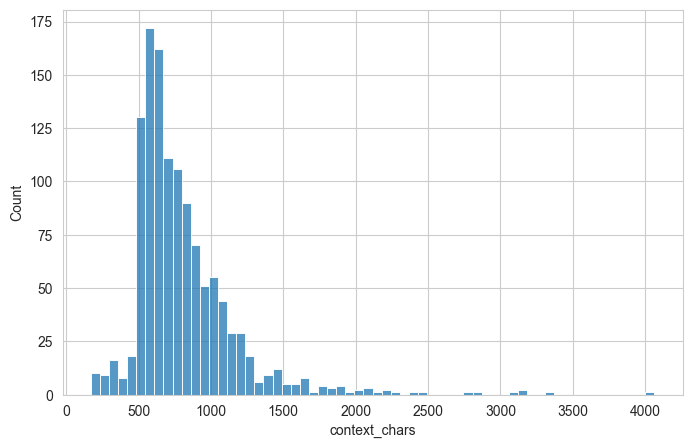

In [13]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_chars"])

<Axes: xlabel='context_words', ylabel='Count'>

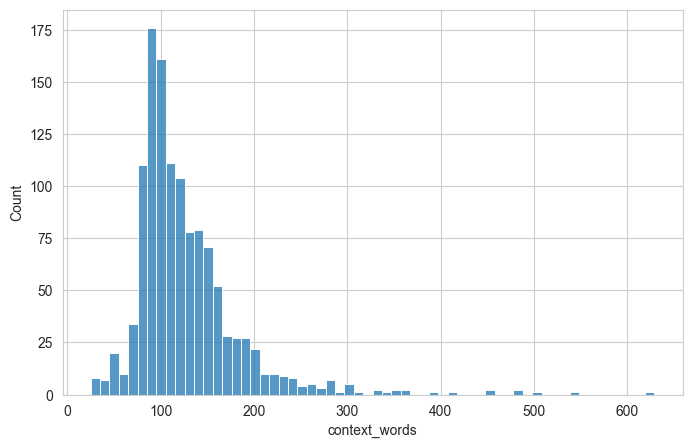

In [14]:
plt.figure(figsize=[8, 5])
sns.histplot(df_selected.drop_duplicates(subset="context")["context_words"])

In [ ]:
# create original json structure for only a subset of questions, used for tests and fine-tuning 
# this file will be used by the evaluation.py file 

df = pd.read_csv("dataset.csv")
df_sel = df[0:500]
df_sel.head(2)

create_json_subset(df_sel)

# RAG architecture

Steps:

**Data Indexing**

Converting text data into a searchable database of vector embeddings, which represent the meaning of the text in a format that computers can easily understand.
- **Documents Chunking**: The collection of documents is split into smaller chunks of text. This allows for more precise and relevant pieces of information to be fed into the language model when needed, avoiding information overload.
- **Vector Embeddings**: The chunks of text are then transformed into vector embeddings. These embeddings encode the meaning of natural language text into numerical representations.
- **Vector Database**: Finally, the vector embeddings are stored in a vector database, making them easily searchable.

**Documents -> Text chunks -> Vector Embeddings -> Vector DB**

**Load -> Split -> Embed -> Store**

## Convert the pandas context to Langchain documents 

In [2]:
df = pd.read_csv("dataset.csv")

langchain_docs = convert_context_to_langchain_docs(df)

In [3]:
print(len(langchain_docs))
print(langchain_docs[0])
print(langchain_docs[1])

1204
page_content='The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France. They were descended from Norse ("Norman" comes from "Norseman") raiders and pirates from Denmark, Iceland and Norway who, under their leader Rollo, agreed to swear fealty to King Charles III of West Francia. Through generations of assimilation and mixing with the native Frankish and Roman-Gaulish populations, their descendants would gradually merge with the Carolingian-based cultures of West Francia. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.' metadata={'title': 'Normans'}
page_content='The Norman dynasty had a major political, cultural and military impact on medieval Europe and even the Near East. The Normans were famed for their martial spirit and eventually for their Christ

## Vector database

In [3]:
embeddings_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embeddings_model)

db_dir = os.path.join(os.getcwd(), "vector_databases")


In [12]:
create_vector_store(langchain_docs, embeddings, store_name="test_vector_store", db_dir=db_dir, chunk_size=200, chunk_overlap=15)

Vector store test_vector_store already exists. No need to initialize.


## Querying the vector database 

In [ ]:
query = "How is the weather today in Milan?"
store_name =  "test_vector_store"
relevant_docs = query_vector_store(store_name, query, embeddings, db_dir, k=3, score_threshold=0.1)

print(relevant_docs)

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:90: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
No relevant docs were retrieved using the relevance score threshold 0.1


[]


In [6]:
query = "Who were the normans?"
store_name =  "test_vector_store"
relevant_docs = query_vector_store(store_name, query, embeddings, db_dir, k=3, score_threshold=0.1)

print(len(relevant_docs))

for doc in relevant_docs:
    print(doc.page_content)

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:91: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(


3
The Normans (Norman: Nourmands; French: Normands; Latin: Normanni) were the people who in the 10th and 11th centuries gave their name to Normandy, a region in France
. The distinct cultural and ethnic identity of the Normans emerged initially in the first half of the 10th century, and it continued to evolve over the succeeding centuries.
. The Normans were famed for their martial spirit and eventually for their Christian piety, becoming exponents of the Catholic orthodoxy into which they assimilated


## Run the RAG over a subset of questions and save the answers 

In [5]:
df_to_test = pd.read_csv("dataset.csv")
df_to_test = df_to_test[0:500]

In [ ]:
embeddings_model = "text-embedding-3-small"
embeddings = OpenAIEmbeddings(model=embeddings_model)

save_llm_answers(df_to_test, langchain_docs, embeddings, embeddings_model, chunk_size=150, filename="test_predictions.json")

/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_150_text-embedding-3-small
Vector store chroma_db_openai already exists. No need to initialize.


  0%|          | 0/500 [00:00<?, ?it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:91: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
 81%|████████  | 403/500 [08:27<03:06,  1.92s/it]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 451, 'title': 'Force'}, page_content='from ordered to more random conditions as entropy increases'), -0.10112879189601554), (Document(metadata={'start_index': 103, 'title': 'Force'}, page_content='. This is often due to macrophysical co

## RAG Fine-tuning 

Comments
Peak distribution for number of characters in the documents is ~600 words. 
- smaller chunks: reduced noise from irrelevant content - works well with dense embeddings*
- larger chunks: preserves context better; ideal if queries require full document context, works well with hybrid search*

TEXT CHUNKING 

1. CHARACTER SPLITTING : divide the text into N-character sized chunks. Can split words in the middle. 
2. RECURSIVE CHARACTER SPLITTING: preserves sentences. Avoids splitting sentences midword (note that RecursiveCharacterTextSplitter with separator does exactly that). Split the
document where a double new line is present, then, if the chunk size is still exceeded, split at new lines, and so on.
3. SEMANTIC SPLITTING: keeps related content together. Use embeddings to split based on meaning.
+ other techniques

EMBEDDINGS 
Create fixed-length vector representation of text, focusing on semanting meaning for tasks like similarity comparison. 
Most up to date embedding models, both proprietary and open source, with performance metrics across different tasks: https://huggingface.co/spaces/mteb/leaderboard 
This contains also a "retrieval" column with performance metrics. Click on the column to sort the models.
Interesting article: https://www.mongodb.com/developer/products/atlas/choose-embedding-model-rag/


In [2]:
df = pd.read_csv("dataset.csv")
df_to_test = df[0:500]

langchain_docs = convert_context_to_langchain_docs(df)

fine_tune_rag(df_to_test, langchain_docs)

Running gpt-3.5-turbo - 100 - text-embedding-3-small
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 200 - text-embedding-3-small
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 400 - text-embedding-3-small
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 500 - text-embedding-3-small
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 600 - text-embedding-3-small
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 100 - text-embedding-3-large
Results already exist for these settings: skipping!
Running gpt-3.5-turbo - 200 - text-embedding-3-large
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_200_text-embedding-3-large
Vector store chroma_db_openai already exists. No need to initialize.


  0%|          | 0/500 [00:00<?, ?it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:96: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
 17%|█▋        | 83/500 [01:30<06:23,  1.09it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 226, 'title': 'Normans'}, page_content='. This relationship eventually produced closer ties of blood through the marriage of Emma, sister of Duke Richard II of Normandy, and King Ethelred II of England'), 0.14839595185433918), (Document(

Running gpt-3.5-turbo - 400 - text-embedding-3-large
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_400_text-embedding-3-large

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


  3%|▎         | 13/500 [00:15<10:49,  1.33s/it]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 315, 'title': 'Huguenot'}, page_content='. Andrew Lortie (born André Lortie), a leading Huguenot theologian and writer who led the exiled community in London, became known for articulating their criticism of the Pope and the doctrine of transubstantiation during Mass.'), 0.017011918166117357), (Document(metadata={'start_index': 347, 'title': 'Harvard_University'}, page_content='. Derived from William Ellery Channing and Ralph Waldo Emerson, these convictions were focused on the dignity and worth of human nature, the right and ability of each person to perceive truth, and the indwelling God in each person.'), -0.007391950058660557), (Document(metadata={'start_index': 334, 'title': 'Huguenot'}, page_content="

Running gpt-3.5-turbo - 500 - text-embedding-3-large
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_500_text-embedding-3-large

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


  3%|▎         | 13/500 [00:15<09:47,  1.21s/it]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 315, 'title': 'Huguenot'}, page_content='. Andrew Lortie (born André Lortie), a leading Huguenot theologian and writer who led the exiled community in London, became known for articulating their criticism of the Pope and the doctrine of transubstantiation during Mass.'), 0.017036363338253646), (Document(metadata={'start_index': 347, 'title': 'Harvard_University'}, page_content='. Derived from William Ellery Channing and Ralph Waldo Emerson, these convictions were focused on the dignity and worth of human nature, the right and ability of each person to perceive truth, and the indwelling God in each person.'), -0.007391950058660557), (Document(metadata={'start_index': 310, 'title': 'Huguenot'}, page_content='

Running gpt-3.5-turbo - 600 - text-embedding-3-large
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_600_text-embedding-3-large

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


  3%|▎         | 13/500 [00:12<07:29,  1.08it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 517, 'title': 'Huguenot'}, page_content='. William Farel was a student of Lefevre who went on to become a leader of the Swiss Reformation, establishing a Protestant government in Geneva. Jean Cauvin (John Calvin), another student at the University of Paris, also converted to Protestantism. Long after the sect was suppressed by Francis I, the remaining French Waldensians, then mostly in the Luberon region, sought to join William Farel, Calvin and the Reformation, and Olivetan published a French Bible for them. The French Confession of 1559 shows a decidedly Calvinistic influence'), 0.0005437957537586247), (Document(metadata={'start_index': 0, 'title': 'Harvard_University'}, page_content='Charles W. Eliot, pr

Running gpt-3.5-turbo - 100 - text-embedding-ada-002
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_100_text-embedding-ada-002

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


Running gpt-3.5-turbo - 200 - text-embedding-ada-002
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_200_text-embedding-ada-002

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


Running gpt-3.5-turbo - 400 - text-embedding-ada-002
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_400_text-embedding-ada-002

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


100%|██████████| 500/500 [08:01<00:00,  1.04it/s] 


Running gpt-3.5-turbo - 500 - text-embedding-ada-002
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_500_text-embedding-ada-002

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


100%|██████████| 500/500 [07:17<00:00,  1.14it/s]


Running gpt-3.5-turbo - 600 - text-embedding-ada-002
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_600_text-embedding-ada-002

--- Creating vector store chroma_db_openai ---
--- Finished creating vector store chroma_db_openai ---


100%|██████████| 500/500 [07:02<00:00,  1.18it/s]


In [2]:
df_all_res = collect_all_results('/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/eval_results/initial_eval_results')
df_all_res.sort_values(by="HasAns_f1", ascending=False, inplace=True)
df_all_res.to_csv("eval_results/initial_eval_results/df_all_results.csv", index=False)

In [3]:
df_all_res

,exact,f1,total,HasAns_exact,HasAns_f1,HasAns_total,NoAns_exact,NoAns_f1,NoAns_total,experiment
13,44.2,49.137730,500,62.869198,73.286351,237,27.376426,27.376426,263,eval_pred_500_400_text-embedding-3-large_gpt-3...
9,42.8,48.107636,500,61.603376,72.800920,237,25.855513,25.855513,263,eval_pred_500_500_text-embedding-ada-002_gpt-3...
0,45.4,50.499295,500,62.025316,72.783323,237,30.418251,30.418251,263,eval_pred_500_400_text-embedding-ada-002_gpt-3...
8,47.6,53.473288,500,59.071730,71.462632,237,37.262357,37.262357,263,eval_pred_500_200_text-embedding-3-large_gpt-3...
5,42.6,48.644239,500,58.649789,71.401349,237,28.136882,28.136882,263,eval_pred_500_500_text-embedding-3-large_gpt-3...
12,41.4,47.387078,500,58.227848,70.858814,237,26.235741,26.235741,263,eval_pred_500_600_text-embedding-ada-002_gpt-3...
11,43.0,48.190065,500,58.649789,69.599294,237,28.897338,28.897338,263,eval_pred_500_600_text-embedding-3-small_gpt-3...
1,45.2,50.103369,500,58.649789,68.994450,237,33.079848,33.079848,263,eval_pred_500_400_text-embedding-3-small_gpt-3...
4,41.8,47.506821,500,56.118143,68.157851,237,28.897338,28.897338,263,eval_pred_500_600_text-embedding-3-large_gpt-3...
10,42.4,47.814628,500,55.274262,66.697528,237,30.798479,30.798479,263,eval_pred_500_500_text-embedding-3-small_gpt-3...


# Investigate the results

In [ ]:
# Pick the best results and merge the scores by question id to the original df in order to inspect the errors.
# The idea is to understand why the results are so poor for the NoAns questions, when the HasAns questions have 
# a high f1 score, in order to understand how the workflow can be optimized

In [4]:
best_result_path = os.path.join(os.getcwd(), "eval_results/initial_eval_results", df_all_res.experiment.iloc[0])
split_path = best_result_path.split("/")
split_path[-1] = split_path[-1].replace("eval_", "")
best_result_path = "/".join(split_path)
best_result_path

'/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/eval_results/initial_eval_results/pred_500_400_text-embedding-3-large_gpt-3.5-turbo.json'

In [5]:
# run the RAG with best parameters, and save also the context
parameters_dict = {
    "chunk_sizes": [400],
    "embed_options": { 
        "text-embedding-3-large": "OpenAI", 
        },
    "models": ["gpt-3.5-turbo"]
}

In [6]:
results_folder = os.path.join(os.getcwd(), "eval_results/debugging_eval_results")
results_folder

if not os.path.exists(results_folder):
    os.mkdir(results_folder)

In [7]:
df = pd.read_csv("dataset.csv")
df_to_test = df[0:500]

langchain_docs = convert_context_to_langchain_docs(df)

fine_tune_rag(df_to_test, langchain_docs, parameters_dict, results_folder=results_folder, save_context=True)

Fine tuning RAG with the following parameters: 
{'chunk_sizes': [400],
 'embed_options': {'text-embedding-3-large': 'OpenAI'},
 'models': ['gpt-3.5-turbo']}
Running gpt-3.5-turbo - 400 - text-embedding-3-large
/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/vector_databases/db_400_text-embedding-3-large
Vector store chroma_db_openai already exists. No need to initialize.


  0%|          | 0/500 [00:00<?, ?it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/rag_fine_tuning.py:96: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  db = Chroma(
  3%|▎         | 13/500 [00:13<07:33,  1.07it/s]/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/.venv/lib/python3.12/site-packages/langchain_core/vectorstores/base.py:1076: UserWarning: Relevance scores must be between 0 and 1, got [(Document(metadata={'start_index': 315, 'title': 'Huguenot'}, page_content='. Andrew Lortie (born André Lortie), a leading Huguenot theologian and writer who led the exiled community in London, became known for articulating their criticism of the Pope and the doctrine of 

In [ ]:
! python eval_results/evaluation.py "/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/eval_results/data_updated_500.json" "/Users/mariadancianu/Desktop/Git Projects/SQuAD_RAG_experiments/eval_results/initial_eval_results/pred_500_400_text-embedding-3-large_gpt-3.5-turbo.json"

In [ ]:
df_merged = merge_results(f1_filepath=os.path.join(os.getcwd(), "eval_results/f1_thresh_by_qid.json"), 
                          exact_filepath=os.path.join(os.getcwd(), "eval_results/exact_thresh_by_qid.json"), 
                          pred_filepath=best_result_path, 
                          filepath_500=os.path.join(os.getcwd(), "eval_results/debugging_eval_results", "pred_500_100_text-embedding-3-large_gpt-3.5-turbo.json"),
                          context_filepath=os.path.join(os.getcwd(), "eval_results/debugging_eval_results", "context_500_100_text-embedding-3-large_gpt-3.5-turbo.json"), 
                          df_questions_filepath="dataset.csv", 
                          filter_500=True)

df_merged.shape

(11873, 17)

In [34]:
df_merged.columns

Index(['question', 'list_idx', 'paragraph_idx', 'question_idx', 'id',
       'is_impossible', 'answer_0', 'answer_1', 'answer_2', 'answer_3',
       'context', 'title', 'answer_4', 'answer_5', 'f1_score', 'exact_score',
       'pred'],
      dtype='object')

In [47]:
df_merged[df_merged.is_impossible][["id", "is_impossible", "f1_score", "exact_score", "question", "pred"]].tail(10)

,id,is_impossible,f1_score,exact_score,question,pred
478,5ad5648b5b96ef001a10ad97,True,0.0,0.0,What does one not need to remain constant in a...,the input
479,5ad5648b5b96ef001a10ad98,True,0.0,0.0,What is more difficult that multiplication?,calculating the discrete logarithm
484,5ad565575b96ef001a10adb2,True,0.0,0.0,What does the complexity of problems not often...,the instance
485,5ad565575b96ef001a10adb3,True,0.0,0.0,What would not create a conflict between a pro...,An algorithm for X that solves any problem in C.
486,5ad565575b96ef001a10adb4,True,1.0,1.0,What problem in C is harder than X?,""""""
487,5ad565575b96ef001a10adb5,True,0.0,0.0,How is a problem set that is hard for expressi...,Complete
492,5ad566375b96ef001a10adce,True,1.0,1.0,"What happens if a problem X is in C, and soft ...",""""""
493,5ad566375b96ef001a10adcf,True,1.0,1.0,What is the softest problem in C?,""""""
494,5ad566375b96ef001a10add0,True,0.0,0.0,What is class contains the the least difficult...,NP-complete
495,5ad566375b96ef001a10add1,True,0.0,0.0,What would indicate that there is a known poly...,Being able to reduce a known NP-complete probl...


In [48]:
print(df_merged.loc[479, "context"].replace(". ", ".\n"))

The most commonly used reduction is a polynomial-time reduction.
This means that the reduction process takes polynomial time.
For example, the problem of squaring an integer can be reduced to the problem of multiplying two integers.
This means an algorithm for multiplying two integers can be used to square an integer.
Indeed, this can be done by giving the same input to both inputs of the multiplication algorithm.
Thus we see that squaring is not more difficult than multiplication, since squaring can be reduced to multiplication.
